### Imports

In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import signal

### Setup

In [2]:
from os import walk

f = []
for (dirpath, dirnames, filenames) in walk("./data/eeg"):
    f.extend(filenames)
    break
csvs = [f"./data/eeg/{filename}" for filename in f[1:]]

In [3]:
file_df = pd.DataFrame(columns=["genre","subject","take","song_name","path"])
# Build csv data into df
for path in csvs:
    genre, subject, take = path.split("/")[-1].split("_")[:3]
    song_name = "_".join(path.split("/")[-1].split("_")[3:])[:-4]
    file_df.loc[len(file_df),:] = [genre,subject,take,song_name,path]

# Make some QOL improvements
file_df["subject"]=  file_df.subject.apply(lambda x: x.title())
#file_df["Song Name"] = file_df.song_name.apply(lambda x: x.replace("_"," ").title())

# file_df
""" WE ONLY NEED THIS ONCE
for file_path in file_df.path:
    temp = pd.read_csv(file_path)
    try:
        start = min(temp.timestamp)
    except:
        file_df = file_df.loc[file_df.path != file_path,:]
    temp["delta"] = temp.timestamp.apply(lambda x: x-start)
    temp.timestamp = [i for i in range(len(temp))]
    temp = temp.loc[:,[c for c in temp.columns if "Unnamed" not in c]]
    temp.to_csv(file_path)
"""

' WE ONLY NEED THIS ONCE\nfor file_path in file_df.path:\n    temp = pd.read_csv(file_path)\n    try:\n        start = min(temp.timestamp)\n    except:\n        file_df = file_df.loc[file_df.path != file_path,:]\n    temp["delta"] = temp.timestamp.apply(lambda x: x-start)\n    temp.timestamp = [i for i in range(len(temp))]\n    temp = temp.loc[:,[c for c in temp.columns if "Unnamed" not in c]]\n    temp.to_csv(file_path)\n'

In [4]:
def get_files(genre=None,subject=None,take=None,song_name=None):
    res = file_df.copy()
    if genre is not None:
        res = res.loc[res.genre == genre,:]
    if subject is not None:
        res = res.loc[res.subject == subject,:]
    if take is not None:
        res = res.loc[res.take == take,:]
    if song_name is not None:
        res = res.loc[res.song_name == song_name,:]
    return res

def get_reads(files):
    res = pd.DataFrame(columns=["timestamp","raw_value","attention",*files.columns])
    for i,file in files.iterrows():
        temp = pd.read_csv(file.path)
        for column in files.columns:
            temp[column] = file[column]
        res = pd.concat([res,temp])
    return res

### Person-Person ###

In [5]:
STAMP_END = 3000
subject_dict = {}
for subject in file_df.subject.unique():
    print(f"\n{subject}\t",end="")
    subject_reads = get_reads(get_files(subject=subject))
    c_reads = subject_reads.loc[subject_reads.genre == "c",:]
    h_reads = subject_reads.loc[subject_reads.genre == "h",:]
    subject_means = pd.DataFrame(columns=["genre","subject","timestamp","raw_value","attention"])
    for i in range(STAMP_END):
        if (i % (STAMP_END//10) == 0):
            print("■",end="")
        c_mean_raw = np.mean(c_reads.loc[c_reads.timestamp == i,"raw_value"])
        c_mean_attn = np.mean(c_reads.loc[c_reads.timestamp == i,"attention"])
        h_mean_raw = np.mean(h_reads.loc[h_reads.timestamp == i,"raw_value"])
        h_mean_attn = np.mean(h_reads.loc[h_reads.timestamp == i,"attention"])
        subject_means.loc[len(subject_means),:] = ["c",subject,i,c_mean_raw,c_mean_attn]
        subject_means.loc[len(subject_means),:] = ["h",subject,i,h_mean_raw,h_mean_attn]
    subject_means.dropna(axis=0,how="any",inplace=True)
    subject_dict[subject] = subject_means
print("\n")


Sean	■■■■■■■■■■
Kunal	■■■■■■■■■■
Alex	■■■■■■■■■■
Simon	■■■■■■■■■■
Nolan	■■■■■■■■■■
Patrick	■■■■■■■■■■



In [6]:
from scipy.stats import pearsonr, ttest_ind
#scipy.stats.ttest_ind(a, b, equal_var=False)
for subject in subject_dict:
    temp = subject_dict[subject]
    temp.timestamp = temp.timestamp.astype(int)
    temp.raw_value = temp.raw_value.astype(float)
    temp.attention = temp.attention.astype(float)
    temp = temp.loc[temp.timestamp <= 3000,:]
    c_raw = temp.loc[temp.genre == "c","raw_value"]
    h_raw = temp.loc[temp.genre == "h","raw_value"]
    c_attn = temp.loc[temp.genre == "c","attention"]
    h_attn = temp.loc[temp.genre == "h","attention"]
    print(f"\n\n\n=== {subject.upper()} ===")
    print("=== PEARSON ===")
    r_raw,p_raw = pearsonr(c_raw,h_raw)
    r_attn,p_attn = pearsonr(c_attn,h_attn)
    if p_raw < 0.05:
        print(f"Raw Trace:\tr={r_raw}\tp={p_raw}")
    if p_attn < 0.05:
        print(f"Attention:\tr={r_attn}\tp={p_attn}")
    print("=== WELCH ===")
    f_raw,p_raw = ttest_ind(c_raw,h_raw,equal_var=False)
    f_attn,p_attn = ttest_ind(c_attn,h_attn,equal_var=False)
    if p_raw < 0.05:
        print(f"Raw Trace:\tf={f_raw}\tp={p_raw}")
    if p_attn < 0.05:
        print(f"Attention:\tf={f_attn}\tp={p_attn}")




=== SEAN ===
=== PEARSON ===
Raw Trace:	r=-0.04737918185613432	p=0.0094469694848743
Attention:	r=-0.07907280561735305	p=1.4511129082560716e-05
=== WELCH ===
Attention:	f=-6.516095599084976	p=7.905199891640497e-11



=== KUNAL ===
=== PEARSON ===
Attention:	r=0.08751214048621153	p=1.5830826546607229e-06
=== WELCH ===



=== ALEX ===
=== PEARSON ===
Attention:	r=-0.22828010573017815	p=9.148273468928713e-37
=== WELCH ===
Raw Trace:	f=-6.359846872278352	p=2.178899489062419e-10
Attention:	f=-19.520900798888476	p=8.452420642000119e-82



=== SIMON ===
=== PEARSON ===
Raw Trace:	r=0.0376432465441416	p=0.039238501979184
Attention:	r=0.6749794321708081	p=0.0
=== WELCH ===
Raw Trace:	f=-2.788429038554942	p=0.0053131270958177235
Attention:	f=23.88226564089994	p=2.28032430823055e-120



=== NOLAN ===
=== PEARSON ===
Attention:	r=-0.08928715206269576	p=9.671557250066596e-07
=== WELCH ===
Raw Trace:	f=-5.980390127925433	p=2.359451253263769e-09
Attention:	f=-95.55522680598797	p=0.0



=== PATRICK 

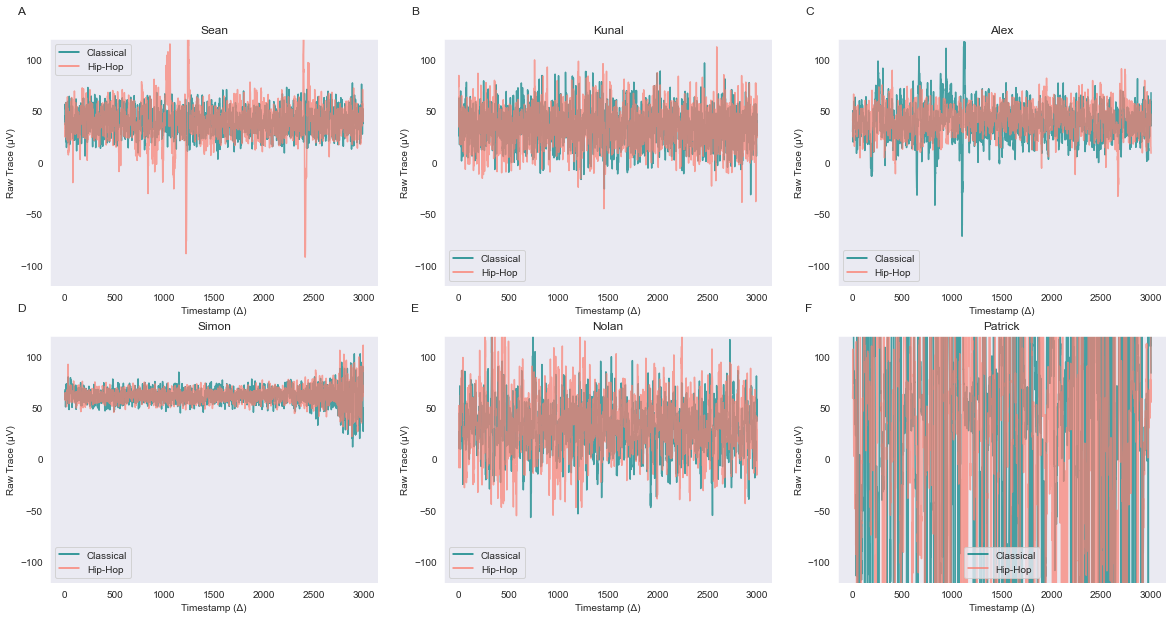

In [7]:
import string

sns.set_palette("Set2")
sns.set_style("dark")
fig,axes = plt.subplots(2,3,figsize=(20,10))
for subject,ax in zip(subject_dict,axes.flatten()):
    temp = subject_dict[subject]
    temp.timestamp = temp.timestamp.astype(int)
    temp.raw_value = temp.raw_value.astype(float)
    g = sns.lineplot(data = temp, x="timestamp",y="raw_value",hue="genre",ax=ax,alpha=0.7,palette=["teal","salmon"])
    g.set_title(subject)
    g.set_ylabel("Raw Trace (μV)")
    g.set_xlabel("Timestamp (Δ)")
    g.set_ylim(-120,120)
    new_labels = ['Classical', 'Hip-Hop']
    for t, l in zip(g.legend().texts, new_labels): t.set_text(l)
for i, a in enumerate(axes.flatten()):
    a.text(-0.1, 1.1, string.ascii_uppercase[i], transform=a.transAxes,fontsize=12)

plt.savefig("./Figures/f1.png",dpi=300)

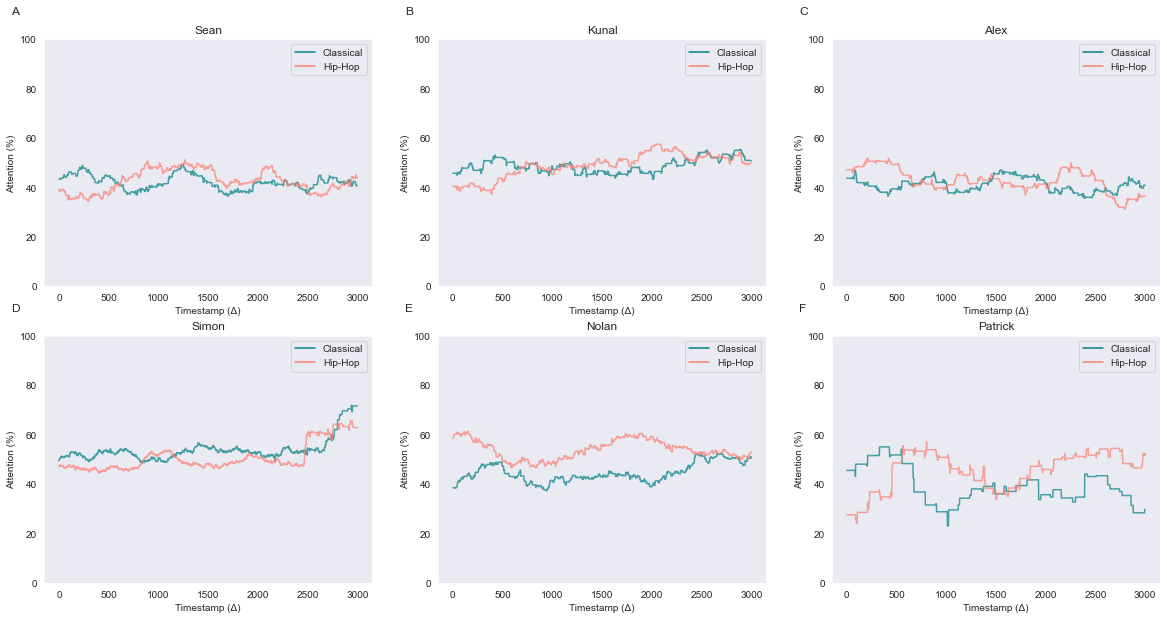

In [8]:


sns.set_palette("Set2")
sns.set_style("dark")
fig,axes = plt.subplots(2,3,figsize=(20,10))
for subject,ax in zip(subject_dict,axes.flatten()):
    temp = subject_dict[subject]
    temp.timestamp = temp.timestamp.astype(int)
    temp.attention = temp.attention.astype(float)
    g = sns.lineplot(data = temp, x="timestamp",y="attention",hue="genre",ax=ax,alpha=0.7,palette=["teal","salmon"])
    g.set_title(subject)
    g.set_ylabel("Attention (%)")
    g.set_xlabel("Timestamp (Δ)")
    g.set_ylim(0,100)
    new_labels = ['Classical', 'Hip-Hop']
    for t, l in zip(g.legend().texts, new_labels): t.set_text(l)
for i, a in enumerate(axes.flatten()):
    a.text(-0.1, 1.1, string.ascii_uppercase[i], transform=a.transAxes,fontsize=12)
plt.savefig("./Figures/f2.png",dpi=300)

### Genre-Genre ###

In [9]:
STAMP_END = 3400
genre_dict = {}
for genre in file_df.genre.unique():
    print(f"\n{genre}\t",end="")
    genre_reads = get_reads(get_files(genre=genre))
    subject_reads = {}
    for subject in file_df.subject.unique():
        subject_reads[subject] = genre_reads.loc[genre_reads.subject == subject,:]
    genre_means = pd.DataFrame(columns=["genre","subject","timestamp","raw_value","attention"])
    for i in range(STAMP_END):
        if (i % (STAMP_END//10) == 0):
            print("■",end="")
        for subject in subject_reads:
            subject_mean_raw = np.mean(subject_reads[subject].loc[subject_reads[subject].timestamp == i,"raw_value"])
            subject_mean_attn = np.mean(subject_reads[subject].loc[subject_reads[subject].timestamp == i,"attention"])
            genre_means.loc[len(genre_means),:] = [genre,subject,i,subject_mean_raw,subject_mean_attn]
    genre_means.dropna(axis=0,how="any",inplace=True)
    genre_dict[genre] = genre_means
print("\n")


h	■■■■■■■■■■
c	■■■■■■■■■■



/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


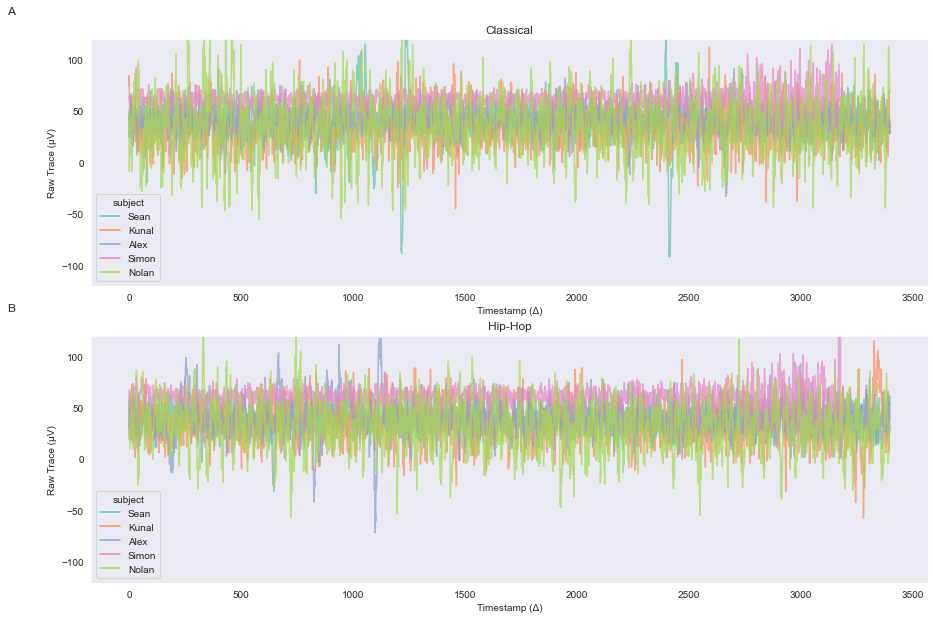

In [10]:
import string

sns.set_palette("Set2")
sns.set_style("dark")
labels = ['Classical', 'Hip-Hop']
fig,axes = plt.subplots(2,1,figsize=(15,10))
for genre,ax,lbl in zip(genre_dict,axes.flatten(),labels):
    temp = genre_dict[genre]
    temp = temp.loc[temp.subject != "Patrick",:]
    temp.timestamp = temp.timestamp.astype(int)
    temp.raw_value = temp.raw_value.astype(float)
    g = sns.lineplot(data = temp, x="timestamp",y="raw_value",hue="subject",ax=ax,alpha=0.7)
    g.set_title(lbl)
    g.set_ylabel("Raw Trace (μV)")
    g.set_xlabel("Timestamp (Δ)")
    g.set_ylim(-120,120)
for i, a in enumerate(axes.flatten()):
    a.text(-0.1, 1.1, string.ascii_uppercase[i], transform=a.transAxes,fontsize=12)

plt.savefig("./Figures/f1.png",dpi=300)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


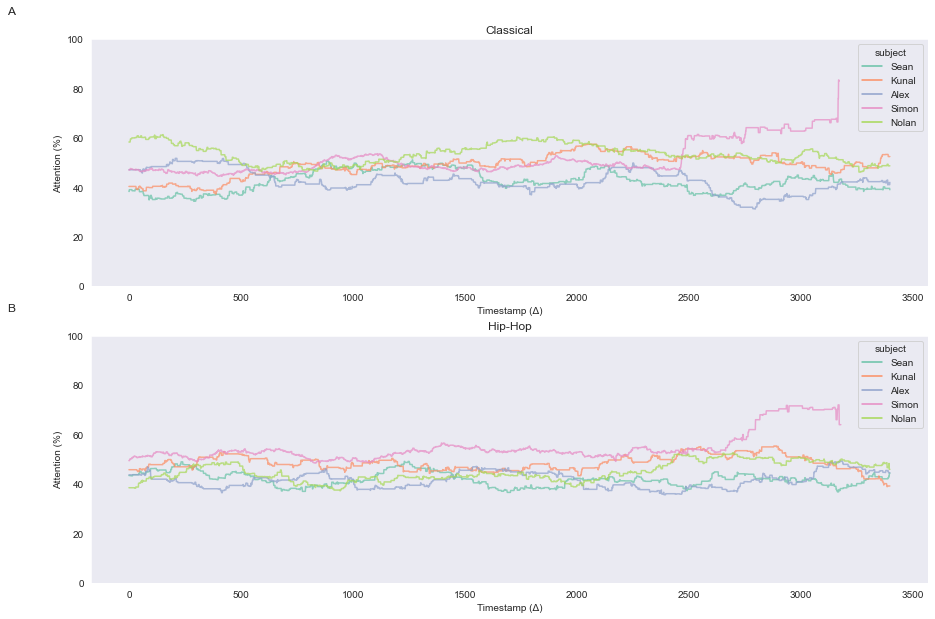

In [11]:
import string

sns.set_palette("Set2")
sns.set_style("dark")
labels = ['Classical', 'Hip-Hop']
fig,axes = plt.subplots(2,1,figsize=(15,10))
for genre,ax,lbl in zip(genre_dict,axes.flatten(),labels):
    temp = genre_dict[genre]
    temp = temp.loc[temp.subject != "Patrick",:]
    temp.timestamp = temp.timestamp.astype(int)
    temp.attention = temp.attention.astype(float)
    g = sns.lineplot(data = temp, x="timestamp",y="attention",hue="subject",ax=ax,alpha=0.7)
    g.set_title(lbl)
    g.set_ylabel("Attention (%)")
    g.set_xlabel("Timestamp (Δ)")
    g.set_ylim(0,100)
for i, a in enumerate(axes.flatten()):
    a.text(-0.1, 1.1, string.ascii_uppercase[i], transform=a.transAxes,fontsize=12)

plt.savefig("./Figures/f1.png",dpi=300)

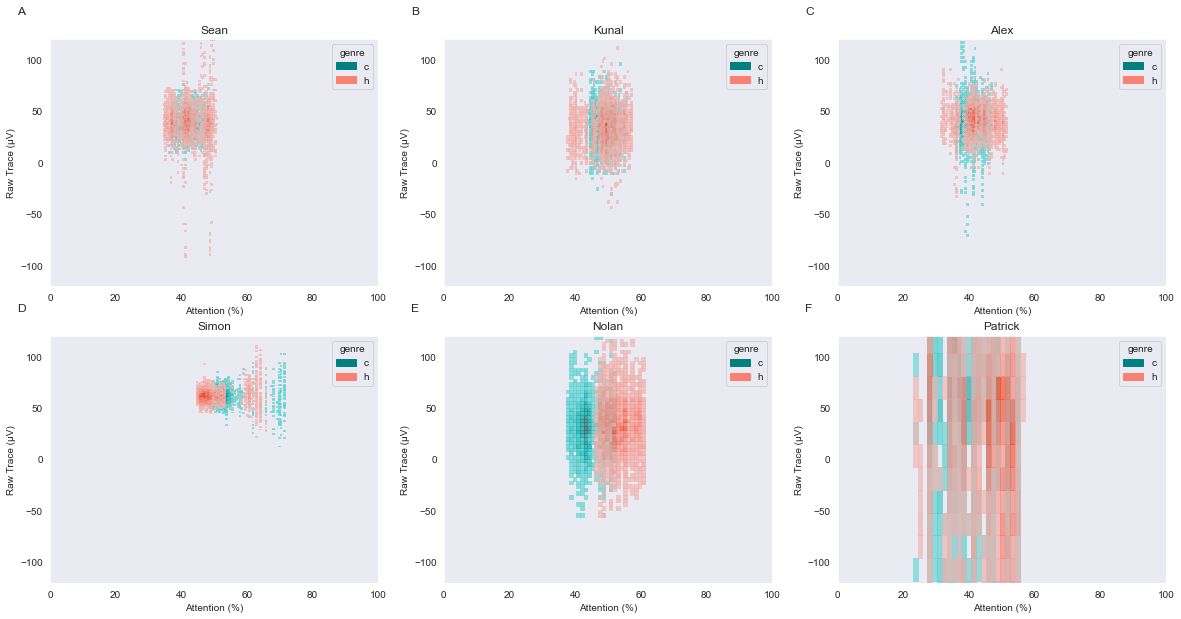

In [12]:
import string

sns.set_palette("Set2")
sns.set_style("dark")
fig,axes = plt.subplots(2,3,figsize=(20,10))
for subject,ax in zip(subject_dict,axes.flatten()):
    temp = subject_dict[subject]
    temp.attention = temp.attention.astype(float)
    temp.raw_value = temp.raw_value.astype(float)
    g = sns.histplot(data = temp, x="attention",y="raw_value",hue="genre",ax=ax,alpha=0.7,palette=["teal","salmon"])
    g.set_title(subject)
    g.set_ylabel("Raw Trace (μV)")
    g.set_xlabel("Attention (%)")
    g.set_ylim(-120,120)
    g.set_xlim(0,100)
for i, a in enumerate(axes.flatten()):
    a.text(-0.1, 1.1, string.ascii_uppercase[i], transform=a.transAxes,fontsize=12)

plt.savefig("./Figures/f1.png",dpi=300)

In [13]:
heat = temp.pivot_table(columns='attention', values='raw_value')
heat

attention,23.000000,24.125000,24.500000,25.750000,27.500000,28.333333,28.500000,28.750000,29.500000,29.666667,...,53.875000,54.000000,54.125000,54.250000,54.375000,54.625000,54.750000,55.000000,55.500000,57.125000
raw_value,-239.25,39.395833,50.541667,-46.125,22.339888,99.634783,64.434466,51.752294,93.909794,113.388889,...,29.617788,-213.364583,53.350904,-30.791667,29.633523,256.0,-64.4375,4.8875,31.125,71.225


In [14]:
file_df

,genre,subject,take,song_name,path
0,h,Sean,1,practice,./data/eeg/h_sean_1_practice.csv
1,c,Sean,1,bach_vivace,./data/eeg/c_sean_1_bach_vivace.csv
2,c,Kunal,1,brahms_cello_sonata_no1,./data/eeg/c_kunal_1_brahms_cello_sonata_no1.csv
3,h,Alex,1,king_kunta,./data/eeg/h_alex_1_king_kunta.csv
4,c,Simon,3,dvorak_american_quartet,./data/eeg/c_simon_3_dvorak_american_quartet.csv
...,...,...,...,...,...
252,c,Nolan,1,jupiter_jollity,./data/eeg/c_nolan_1_jupiter_jollity.csv
253,h,Simon,2,$t,./data/eeg/h_simon_2_$t.csv
254,c,Kunal,1,bach_gleich_wie_der_regen,./data/eeg/c_kunal_1_bach_gleich_wie_der_regen...
255,c,Simon,1,chopen_nocturne,./data/eeg/c_simon_1_chopen_nocturne.csv


In [15]:
CUTOFF = 3000
SEG_CUTOFF = 31
spectrograms = pd.DataFrame(columns=["subject","genre","take","song", "spectrogram"])
for subject in file_df.subject.unique():
    print(f"\n{subject}\t",end="")
    subject_reads = get_reads(get_files(subject=subject))
    c_reads = subject_reads.loc[subject_reads.genre == "c",:]
    h_reads = subject_reads.loc[subject_reads.genre == "h",:]
    for take in c_reads['take'].unique():
        t_read = c_reads.loc[c_reads['take'] == take, :]
        for song in t_read.song_name.unique():
            s_read = t_read.loc[t_read.song_name == song, :]
            r_read = s_read[:CUTOFF].raw_value.to_numpy().astype('int')
            FREQ, TIME, spectrogram = signal.spectrogram(r_read, fs = 128, nperseg = 96)
            spectrogram = (spectrogram - spectrogram.mean())/spectrogram.std()
            if spectrogram.shape[1] < SEG_CUTOFF:
                continue
            spectrograms.loc[len(spectrograms),:] = [subject,"c",take,song,spectrogram[:,:SEG_CUTOFF]]
    for take in h_reads['take'].unique():
        t_read = h_reads.loc[h_reads['take'] == take, :]
        for song in t_read.song_name.unique():
            s_read = t_read.loc[t_read.song_name == song, :]
            r_read = s_read[:CUTOFF].raw_value.to_numpy().astype('int')
            FREQ, TIME, spectrogram = signal.spectrogram(r_read, fs = 128, nperseg = 96)
            spectrogram = (spectrogram - spectrogram.mean())/spectrogram.std()
            if spectrogram.shape[1] < SEG_CUTOFF:
                continue
            spectrograms.loc[len(spectrograms),:] = [subject,"h",take,song,spectrogram[:,:SEG_CUTOFF]]


Sean	

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr_value = np.array(value)



Kunal	
Alex	
Simon	
Nolan	
Patrick	

In [16]:
# Genre Average Spectrograms for each subject
genre_avg_spectrograms = pd.DataFrame(columns=["subject","genre","avg_spectrogram"])
for subject in spectrograms.subject.unique():
    print(f"\n{subject}\t",end="")
    subject_reads = spectrograms.loc[spectrograms.subject == subject,:]
    c_reads = subject_reads.loc[subject_reads.genre == "c",:]
    h_reads = subject_reads.loc[subject_reads.genre == "h",:]
    c_avg_spectrogram = c_reads['spectrogram'].sum(axis=0)
    c_avg_spectrogram = (c_avg_spectrogram - c_avg_spectrogram.mean())/c_avg_spectrogram.std()
    h_avg_spectrogram = h_reads['spectrogram'].sum(axis=0)
    h_avg_spectrogram = (h_avg_spectrogram - h_avg_spectrogram.mean())/h_avg_spectrogram.std()
    genre_avg_spectrograms.loc[len(genre_avg_spectrograms),:] = [subject,"h",h_avg_spectrogram]
    genre_avg_spectrograms.loc[len(genre_avg_spectrograms),:] = [subject,"c",c_avg_spectrogram]


Sean	
Kunal	
Alex	
Simon	
Nolan	
Patrick	

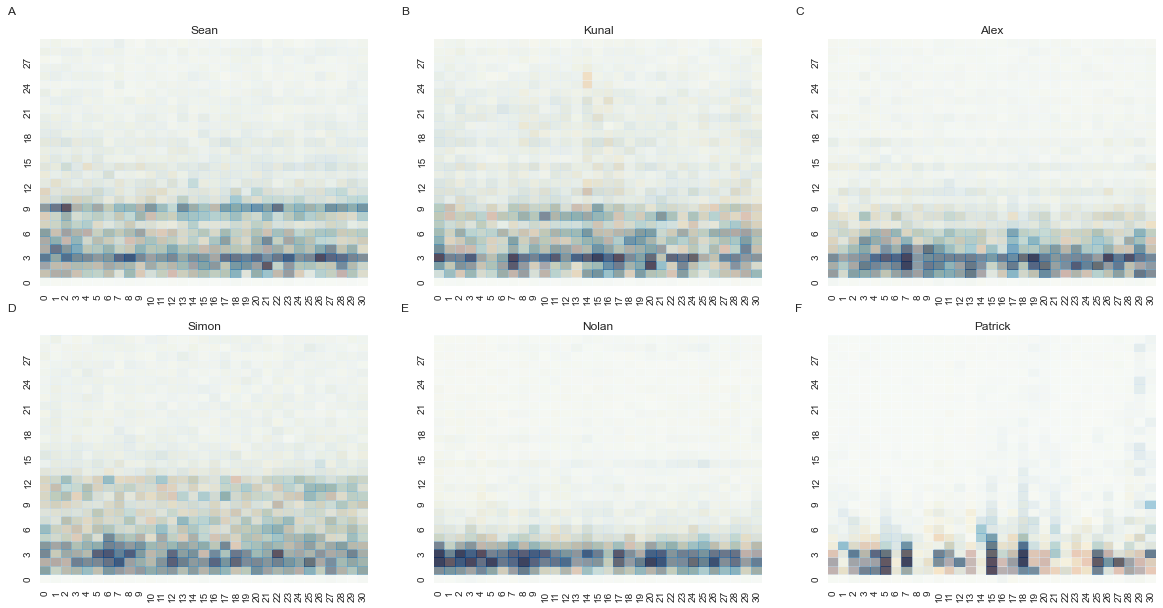

In [17]:
import string

fig,axes = plt.subplots(2,3,figsize=(20,10))
for subject,ax in zip(genre_avg_spectrograms.subject.unique(),axes.flatten()):
    temp = genre_avg_spectrograms[genre_avg_spectrograms.subject == subject]
    h_avg = temp.avg_spectrogram.loc[temp.genre == 'h'].to_numpy()[0]
    c_avg = temp.avg_spectrogram.loc[temp.genre == 'c'].to_numpy()[0]
    g1 = sns.heatmap(h_avg, vmax = 5, ax = ax, alpha = 0.7, cmap = 'YlOrBr', cbar=False)
    g1.invert_yaxis()
    g1.set_ylim(0,30)
    g1.set_title(subject)
    g2 = sns.heatmap(c_avg, vmax = 5, ax = ax, alpha = 0.6, cmap = 'Blues', cbar=False)
    g2.invert_yaxis()
    g2.set_ylim(0,30)
    g2.set_title(subject)
for i, a in enumerate(axes.flatten()):
    a.text(-0.1, 1.1, string.ascii_uppercase[i], transform=a.transAxes,fontsize=12)

plt.savefig("./Figures/avg_spectrograms.png",dpi=300)

In [18]:
spectrograms

,subject,genre,take,song,spectrogram
0,Sean,c,1,bach_vivace,"[[-0.29816026805445683, -0.3422133635594238, -..."
1,Sean,c,1,rachmaninov_concerto_2,"[[-0.5429668837161259, -0.47225809978609057, -..."
2,Sean,c,1,chopen_nocturne,"[[-0.5024315697426777, -0.5021363247874217, -0..."
3,Sean,c,1,deep_river,"[[-0.5003225499264563, -0.4696484368857303, -0..."
4,Sean,c,1,bach_gleich_wie_der_regen,"[[-0.4318594595056852, -0.44242575235935344, -..."
...,...,...,...,...,...
180,Patrick,h,1,power,"[[-0.14329550690391818, -0.14926299149969935, ..."
181,Patrick,h,1,neighbors,"[[-0.1272498357512826, -0.1486277617785428, -0..."
182,Patrick,h,1,windy_ladies,"[[-0.3231579958242145, -0.3262829361749385, -0..."
183,Patrick,h,1,jesus_forgive_me_i_am_a_thot,"[[-0.17764790652585213, -0.18065240431723698, ..."


In [19]:
CUTOFF = 3000
# FREQ_CUTOFF = 31
psds = pd.DataFrame(columns=["subject","genre","take","song", "psd"])
for subject in file_df.subject.unique():
    print(f"\n{subject}\t",end="")
    subject_reads = get_reads(get_files(subject=subject))
    c_reads = subject_reads.loc[subject_reads.genre == "c",:]
    h_reads = subject_reads.loc[subject_reads.genre == "h",:]
    for take in c_reads['take'].unique():
        t_read = c_reads.loc[c_reads['take'] == take, :]
        for song in t_read.song_name.unique():
            s_read = t_read.loc[t_read.song_name == song, :]
            r_read = s_read[:CUTOFF].raw_value.to_numpy().astype('int')
            FREQ, psd = signal.welch(r_read, fs = 128)
            psds.loc[len(psds),:] = [subject,"c",take,song,psd]
    for take in h_reads['take'].unique():
        t_read = h_reads.loc[h_reads['take'] == take, :]
        for song in t_read.song_name.unique():
            s_read = t_read.loc[t_read.song_name == song, :]
            r_read = s_read[:CUTOFF].raw_value.to_numpy().astype('int')
            FREQ, psd = signal.welch(r_read, fs = 128)
            psds.loc[len(psds),:] = [subject,"h",take,song,psd]


Sean	

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr_value = np.array(value)



Kunal	
Alex	
Simon	
Nolan	
Patrick	

In [20]:
# Genre Average Spectrograms for each subject
genre_avg_psds = pd.DataFrame(columns=["subject","genre","avg_psds"])
for subject in psds.subject.unique():
    print(f"\n{subject}\t",end="")
    subject_reads = psds.loc[psds.subject == subject,:]
    c_reads = subject_reads.loc[subject_reads.genre == "c",:]
    h_reads = subject_reads.loc[subject_reads.genre == "h",:]
    c_avg_psd = c_reads['psd'].mean(axis=0)
#     c_avg_psd = (c_avg_psd - c_avg_psd.mean())/c_avg_psd.std()
    h_avg_psd = h_reads['psd'].mean(axis=0)
#     h_avg_spectrogram = (h_avg_spectrogram - h_avg_spectrogram.mean())/h_avg_spectrogram.std()
    genre_avg_psds.loc[len(genre_avg_psds),:] = [subject,"h",h_avg_psd]
    genre_avg_psds.loc[len(genre_avg_psds),:] = [subject,"c",c_avg_psd]


Sean	
Kunal	
Alex	
Simon	
Nolan	
Patrick	

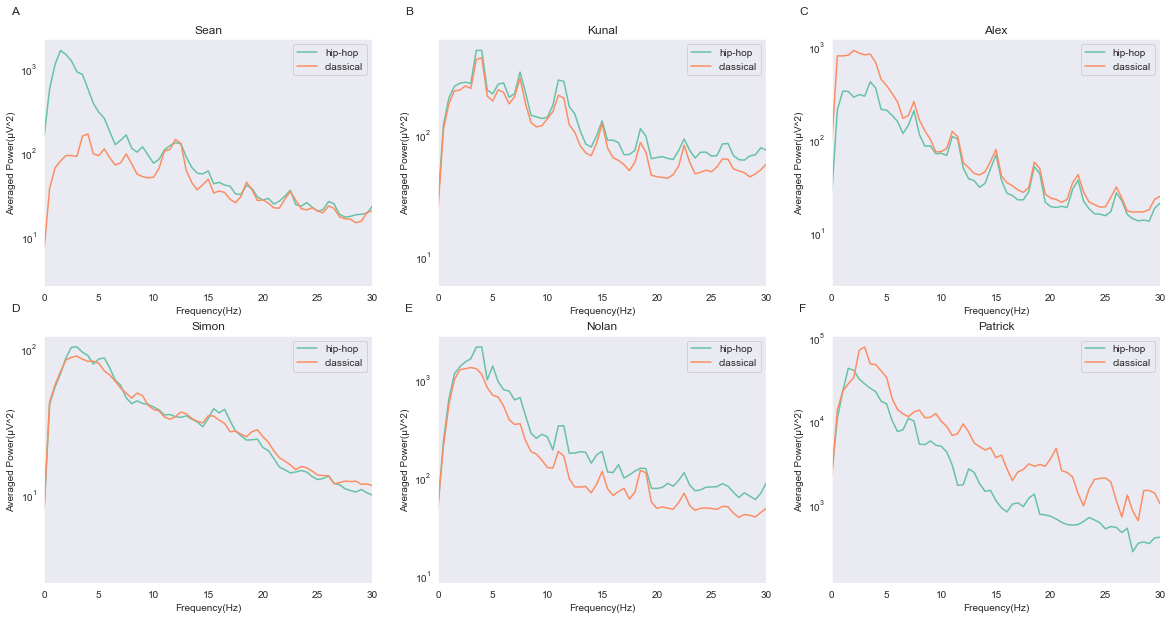

In [21]:
import string

fig,axes = plt.subplots(2,3,figsize=(20,10))
for subject,ax in zip(genre_avg_psds.subject.unique(),axes.flatten()):
    temp = genre_avg_psds[genre_avg_psds.subject == subject]
    h_avg = temp.avg_psds.loc[temp.genre == 'h'].to_numpy()[0]
    c_avg = temp.avg_psds.loc[temp.genre == 'c'].to_numpy()[0]
    g1 = sns.lineplot(x=FREQ, y=h_avg, ax = ax) 
    g1.set_xlim(0,30)
    g1.set_title(subject)
    g2 = sns.lineplot(x=FREQ, y=c_avg, ax = ax) 
    g2.set_xlim(0,30)
    g2.set_yscale('log')
    ax.set_xlabel ("Frequency(Hz)")
    ax.set_ylabel ("Averaged Power(μV^2)")
    ax.legend(labels=['hip-hop', 'classical'])
for i, a in enumerate(axes.flatten()):
    a.text(-0.1, 1.1, string.ascii_uppercase[i], transform=a.transAxes,fontsize=12)

plt.savefig("./Figures/avg_psds.png",dpi=300)